# Adiabatic State Preparation


In [1]:
from rich import print as pprint
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from midstack.interface.math import *
from midstack.interface.analog.operator import *
from midstack.interface.analog.operation import *
from midstack.backend.metric import *
from midstack.backend.task import Task, TaskArgsAnalog
from midstack.backend import QutipBackend

In [2]:
X, Y, Z, I = PauliX(), PauliY(), PauliZ(), PauliI()

In [3]:
Hxx = X @ X
Hz = I @ Z + Z @ I

linear = MathStr(string="0.05*t")

H = -(1 - linear) * Hz + -linear * Hxx

gate = AnalogGate(hamiltonian=H)

Gxx = AnalogGate(hamiltonian=Hxx)

In [4]:
n = 2  # number of qubits
circuit = AnalogCircuit()
circuit.evolve(gate=gate, duration=20)
circuit.evolve(gate=Gxx, duration=10)

In [5]:
args = TaskArgsAnalog(
    n_shots=100,
    fock_cutoff=4,
    metrics={
        "Z": Expectation(operator=((I @ Z + Z @ I) * -0.5)),
        "XX": Expectation(operator=(X @ X) * -1),
    },
    dt=1e-2,
)

task = Task(program=circuit, args=args)

In [6]:
backend = QutipBackend()

expt, args = backend.compile(task=task)

results = backend.run(experiment=expt, args=args)

''

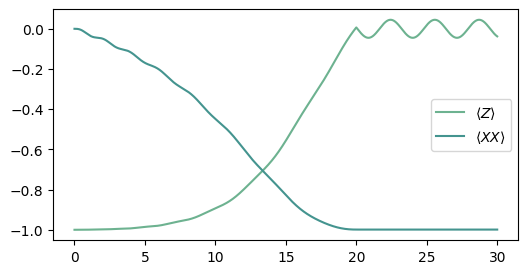

In [7]:
fig, ax = plt.subplots(1, 1, figsize=[6, 3])
colors = sns.color_palette(palette="crest", n_colors=4)

for k, (name, metric) in enumerate(results.metrics.items()):
    ax.plot(results.times, metric, label=f"$\\langle {name} \\rangle$", color=colors[k])
ax.legend()
;

''

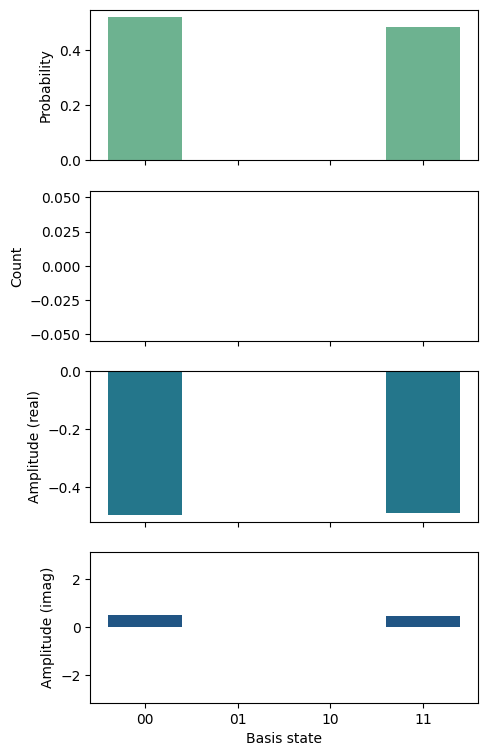

In [8]:
fig, axs = plt.subplots(4, 1, sharex=True, figsize=[5, 9])

state = np.array([basis.real + 1j * basis.imag for basis in results.state])
bases = ["".join(bits) for bits in itertools.product("01", repeat=n)]
counts = {basis: results.counts.get(basis, 0) for basis in bases}

ax = axs[0]
ax.bar(x=bases, height=np.abs(state) ** 2, color=colors[0])
ax.set(ylabel="Probability")


ax = axs[1]
ax.bar(x=bases, height=list(counts.values()), color=colors[1])
ax.set(ylabel="Count")


ax = axs[2]
ax.bar(x=bases, height=state.real, color=colors[2])
ax.set(ylabel="Amplitude (real)")

ax = axs[3]
ax.bar(x=bases, height=state.imag, color=colors[3])
ax.set(xlabel="Basis state", ylabel="Amplitude (imag)", ylim=[-np.pi, np.pi])
;